In [1]:
import os
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt
import gc
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

<h2>Carregamento dos Dados</h2>

In [2]:
input_label = []
output_label = []

In [4]:
a,b = 0,0
ficheiro = open("..\\..\\Dataset\\02-03-2018.csv", "r")
nome_label = ficheiro.readline().split(",")
ficheiro.readline()
ficheiro.readline()
linha = ficheiro.readline()
while(linha != ""):
    linha = linha.split(",")
    out = linha.pop(37)
    if(out == "Benign"): 
        out = 0
        b += 1
    else: 
        out = 1
        a += 1
    output_label.append(out)
    input_label.append(linha)
    linha = ficheiro.readline()
ficheiro.close()
print(str(a) + " " + str(b))

286191 758334


In [5]:
backup_input_label = input_label[:]
backup_output_label = output_label[:]

In [ ]:
input_label = backup_input_label[:]
output_label = backup_output_label[:]

<h2>Normalização dos Dados</h2>

In [8]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [9]:
inp_train,inp_test,out_train,out_test = train_test_split(input_label, input_label, test_size=0.2)

<h2>Construção Das Redes</h2>

In [10]:
input_model = layers.Input(shape = (78,))
enc = layers.Dense(units = 50, activation = "relu", use_bias = True)(input_model)
enc = layers.Dense(units = 20, activation = "relu", use_bias = True)(enc)
enc = layers.Dense(units = 5, activation = "relu")(enc)
dec = layers.Dense(units = 20, activation = "relu", use_bias = True)(enc)
dec = layers.Dense(units = 50, activation = "relu", use_bias = True)(dec)
dec = layers.Dense(units = 78, activation = "relu", use_bias = True)(dec)
auto_encoder = keras.Model(input_model, dec)

In [11]:
encoder = keras.Model(input_model, enc)

decoder_input = layers.Input(shape = (5,))
decoder_layer = auto_encoder.layers[-3](decoder_input)
decoder_layer = auto_encoder.layers[-2](decoder_layer)
decoder_layer = auto_encoder.layers[-1](decoder_layer)
decoder = keras.Model(decoder_input, decoder_layer)

In [12]:
auto_encoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00025), loss = "mean_squared_error", metrics = ['accuracy'])

<h2>Treino</h2>

In [13]:
train = auto_encoder.fit(x = inp_train, y = out_train,validation_split= 0.1, epochs = 5, verbose = 1, shuffle = True)

Epoch 1/5
23502/23502 [==============================] - 34s 1ms/step - loss: 0.0128 - accuracy: 0.4598 - val_loss: 0.0106 - val_accuracy: 0.4086
Epoch 2/5
23502/23502 [==============================] - 25s 1ms/step - loss: 0.0106 - accuracy: 0.5075 - val_loss: 0.0104 - val_accuracy: 0.6286
Epoch 3/5
23502/23502 [==============================] - 28s 1ms/step - loss: 0.0104 - accuracy: 0.5111 - val_loss: 0.0100 - val_accuracy: 0.5765
Epoch 4/5
23502/23502 [==============================] - 28s 1ms/step - loss: 0.0099 - accuracy: 0.5037 - val_loss: 0.0098 - val_accuracy: 0.4617
Epoch 5/5
23502/23502 [==============================] - 27s 1ms/step - loss: 0.0098 - accuracy: 0.5051 - val_loss: 0.0098 - val_accuracy: 0.4023


## Teste

In [15]:
encoder.save("autoencoder5.h5")

In [16]:
input_label = backup_input_label[:]
output_label = backup_output_label[:]

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [18]:
input_label = encoder.predict(input_label).reshape(len(input_label), 5, 1)
output_label = np.array(output_label)

In [19]:
input_label, output_label = shuffle(input_label, output_label)

In [20]:
inp_train, inp_test, out_train, out_test = train_test_split(input_label, output_label, test_size = 0.2)

In [22]:
model = keras.Sequential([
    layers.Input(shape = (5,1)),
    layers.Conv1D(filters = 32, kernel_size = 1, padding = "same", activation = "relu", use_bias = True),
    layers.MaxPool1D(pool_size = 1),
    layers.Conv1D(filters = 16, kernel_size = 1, padding = "same", activation = "relu", use_bias = True),
    layers.MaxPool1D(pool_size = 1),
    layers.Flatten(),
    layers.Dense(units = 2, activation = "softmax")
])

In [23]:
model.compile(optimizer= keras.optimizers.SGD(learning_rate= 0.08), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [24]:
treino = model.fit(x = inp_train, y = out_train, validation_split= 0.1, epochs = 5, shuffle = True,verbose = 1)

Epoch 1/5
23502/23502 [==============================] - 33s 1ms/step - loss: 0.1469 - accuracy: 0.9457 - val_loss: 0.1323 - val_accuracy: 0.9617
Epoch 2/5
23502/23502 [==============================] - 32s 1ms/step - loss: 0.0496 - accuracy: 0.9830 - val_loss: 0.0151 - val_accuracy: 0.9979
Epoch 3/5
23502/23502 [==============================] - 32s 1ms/step - loss: 0.0205 - accuracy: 0.9953 - val_loss: 0.0133 - val_accuracy: 0.9980
Epoch 4/5
23502/23502 [==============================] - 31s 1ms/step - loss: 0.0160 - accuracy: 0.9968 - val_loss: 0.0104 - val_accuracy: 0.9981
Epoch 5/5
23502/23502 [==============================] - 32s 1ms/step - loss: 0.0132 - accuracy: 0.9977 - val_loss: 0.0111 - val_accuracy: 0.9984


In [25]:
res = [np.argmax(resu) for resu in model.predict(inp_test)]

In [26]:
cm = confusion_matrix(y_true = out_test.reshape(len(out_test)), y_pred = np.array(res))

In [27]:
def plot_confusion_matrix(cm, classes, normaliza = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normaliza:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[151199    269]
 [    74  57363]]


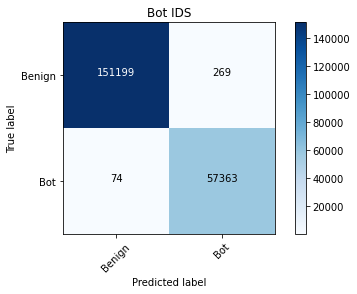

In [28]:
labels = ["Benign", "Bot"]
plot_confusion_matrix(cm = cm, classes = labels, title = "Bot IDS")